PART II

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm, truncnorm
import corner
import arviz as az
import seaborn as sns
import pymc as pm
import emcee
from scipy.stats import gaussian_kde
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
from numpyro import infer
numpyro.set_host_device_count(2) # let's use 2 cores!

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

,mg,bp_rp,parallax
0,10.390250,2.731872,10.000008
1,8.608481,2.025819,10.000029
2,4.267759,0.880858,10.000032
3,10.506658,2.649735,10.000066
4,12.077941,2.940875,10.000111
...,...,...,...
227624,11.758283,2.834036,336.026602
227625,9.521769,2.215609,392.752945
227626,14.129570,4.184836,415.179416
227627,11.883816,2.833697,546.975940


In [3]:
# Filtering parallax > 40
nearby_sel = df.parallax > 40
nearby_df = df[nearby_sel]

In [4]:
# Preparing data
x_data = nearby_df['bp_rp'].values 
y_data = nearby_df['mg'].values  

In [5]:
def linear_model_w_outliers(x_data=None, y_data=None): 
    # Main Sequence (ms) priors
    m_ms = numpyro.sample('m_ms', dist.Uniform(2, 5))  # slope of main sequence
    b_ms = numpyro.sample('b_ms', dist.Uniform(0, 5))  # intercept of main sequence

    σ_ms = numpyro.sample('σ_ms', dist.Normal())
    μ_ms = m_ms * x_data + b_ms
    dist_ms = dist.Normal(μ_ms, σ_ms)  # foreground/inear model/main sequence distribution

    # White Dwarf (wd) priors
    m_wd = numpyro.sample('m_wd', dist.Uniform(2, 5))  # slope of white dwarfs
    b_wd = numpyro.sample('b_wd', dist.Uniform(10, 15))  # intercept of white dwarfs
    
    σ_wd = numpyro.sample('σ_wd', dist.HalfNormal())  # scatter of white dwarfs
    μ_wd = m_wd * x_data + b_wd
    dist_wd = dist.Normal(μ_wd, jnp.sqrt(σ_wd**2 + σ_ms**2)) #background/outliers/White dwarf distribution 

    # Prior for mixture weights (probabilities of being from MS or WD)
    p_ms = numpyro.sample('p_ms', dist.Uniform(0, 1))  # Probability of being from the MS population
    p_wd = 1 - p_ms  # Probability of being from the WD population

    # Mixture model (Categorical distribution)
    mixing_dist = dist.Categorical(probs=jnp.array([p_ms, p_wd])) 
    mixture = dist.MixtureGeneral(mixing_dist, [dist_ms, dist_wd])

    # Likelihood - observed data `y`
    with numpyro.plate("data", len(x_data)):
        y_ = numpyro.sample("obs", mixture, obs=y_data)  
        # Log probabilities to track membership probabilities of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "log_p_ms", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )

In [6]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)

# Define the kernel
kernel = NUTS(linear_model_w_outliers)

# Initialize and run MCMC
mcmc = MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=5000
)
mcmc.run(rng_key_, x_data, y_data)

mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      b_ms      2.56      0.04      2.56      2.49      2.62      1.47      1.58
      b_wd     11.11      1.06     11.18     10.00     12.22      1.00     23.17
      m_ms      2.96      0.02      2.96      2.92      2.99      1.12      2.59
      m_wd      2.25      0.25      2.16      2.00      2.56      1.02      5.54
      p_ms      0.92      0.02      0.92      0.89      0.94      1.03      5.06
      σ_ms      0.50      0.06      0.50      0.44      0.57      1.01      9.59
      σ_wd      2.10      2.07      1.95      0.00      4.29      1.00     21.52

Number of divergences: 0


array([[<Axes: title={'center': 'b_ms'}>,
        <Axes: title={'center': 'b_ms'}>],
       [<Axes: title={'center': 'b_wd'}>,
        <Axes: title={'center': 'b_wd'}>],
       [<Axes: title={'center': 'm_ms'}>,
        <Axes: title={'center': 'm_ms'}>],
       [<Axes: title={'center': 'm_wd'}>,
        <Axes: title={'center': 'm_wd'}>],
       [<Axes: title={'center': 'p_ms'}>,
        <Axes: title={'center': 'p_ms'}>],
       [<Axes: title={'center': 'σ_ms'}>,
        <Axes: title={'center': 'σ_ms'}>],
       [<Axes: title={'center': 'σ_wd'}>,
        <Axes: title={'center': 'σ_wd'}>]], dtype=object)

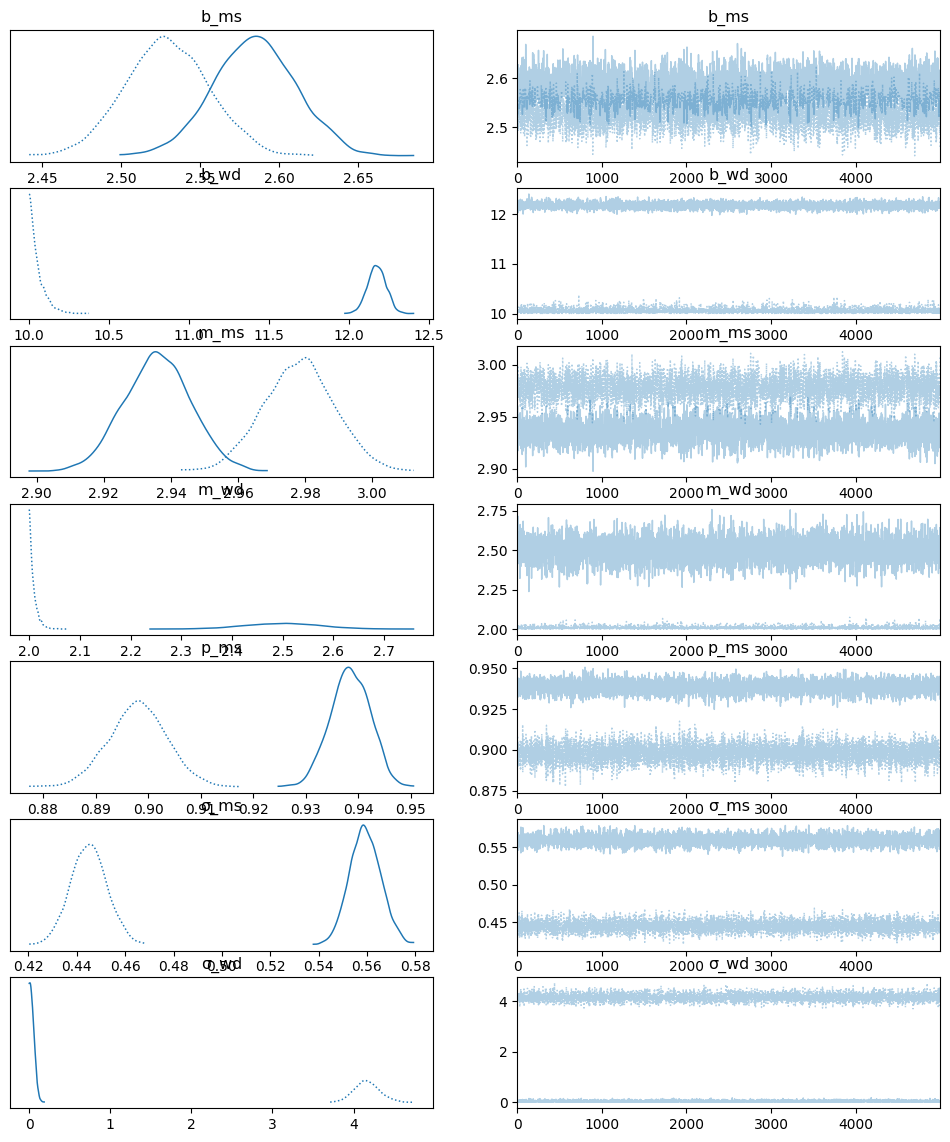

In [7]:
az.plot_trace(mcmc,var_names=['~log_p_ms*'],filter_vars='regex')

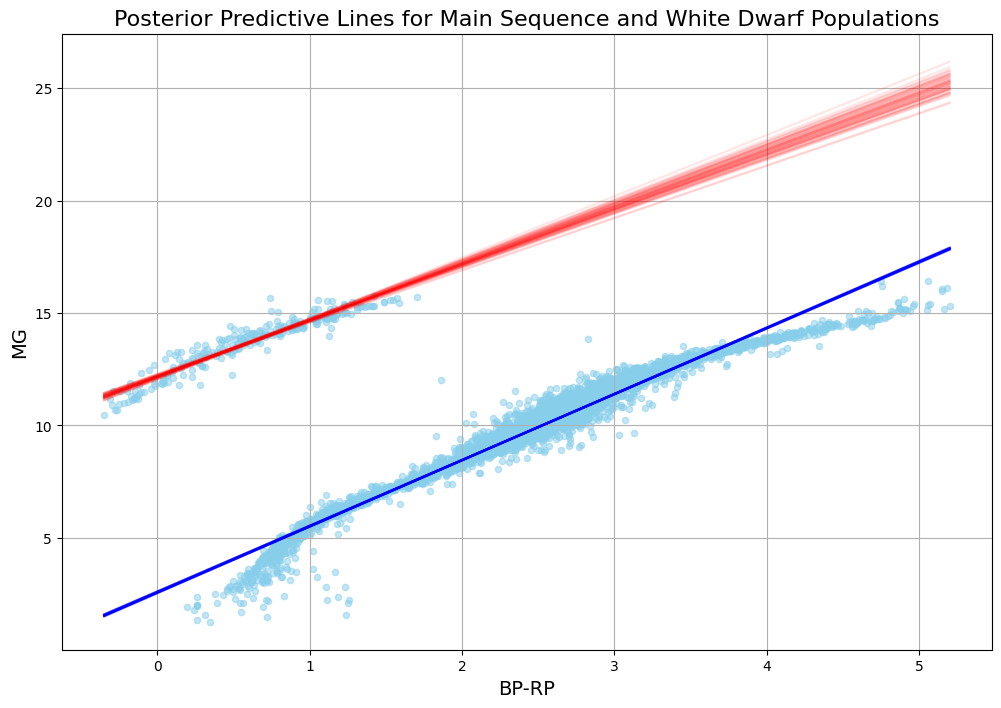

In [8]:
posterior_samples = mcmc.get_samples()

m_ms_samples = posterior_samples['m_ms']
b_ms_samples = posterior_samples['b_ms']
m_wd_samples = posterior_samples['m_wd']
b_wd_samples = posterior_samples['b_wd'] 

x_vals = np.linspace(min(x_data), max(x_data), 50)

plt.figure(figsize=(12,8))
plt.scatter(x_data, y_data, color='skyblue', alpha=0.5, label='Observed Data', s=20)  

for i in range(50):
    m_ms = m_ms_samples[i]
    b_ms = b_ms_samples[i]
    m_wd = m_wd_samples[i]
    b_wd = b_wd_samples[i]  
   
    plt.plot(x_vals, m_ms * x_vals + b_ms, color='blue', alpha=0.1)  
    plt.plot(x_vals, m_wd * x_vals + b_wd, color='red', alpha=0.1)  

plt.xlabel('BP-RP', fontsize=14)
plt.ylabel('MG', fontsize=14)
plt.title('Posterior Predictive Lines for Main Sequence and White Dwarf Populations', fontsize=16)
plt.grid(True)
plt.show()

Q2.Plot the two lines for each of 50 randomly chosen posterior samples from your MCMC. Discuss the quality of the fits, and in particular the constraints. Is the model able to identify the two populations?

Yes. Because we have different discretely defined slopes and y-intercepts, the model is able to identify our foreground and background functions, as we can see the quality of fit for both of them focused on each distribution rather than being confused and messing with the observed data.

Q3. Graduate Students:A

In [9]:
samples = mcmc.get_samples()
samples

{'b_ms': Array([2.569729 , 2.564238 , 2.562413 , ..., 2.5719647, 2.566525 ,
        2.4565902], dtype=float32),
 'b_wd': Array([12.146478, 12.135872, 12.13186 , ..., 10.04753 , 10.077846,
        10.032939], dtype=float32),
 'log_p_ms': Array([[[ 0.00000000e+00, -1.05061958e+02],
         [ 0.00000000e+00, -1.04891037e+02],
         [ 0.00000000e+00, -1.07372299e+02],
         ...,
         [ 0.00000000e+00, -1.14747162e+02],
         [ 0.00000000e+00, -8.58195114e+01],
         [ 0.00000000e+00, -1.09260681e+02]],
 
        [[ 0.00000000e+00, -1.04447830e+02],
         [ 0.00000000e+00, -1.04019135e+02],
         [ 0.00000000e+00, -1.06912003e+02],
         ...,
         [ 0.00000000e+00, -1.13695724e+02],
         [ 0.00000000e+00, -8.52736588e+01],
         [ 0.00000000e+00, -1.08368950e+02]],
 
        [[ 0.00000000e+00, -1.11550476e+02],
         [ 0.00000000e+00, -1.13286827e+02],
         [ 0.00000000e+00, -1.12749191e+02],
         ...,
         [ 0.00000000e+00, -1.24576759e+0

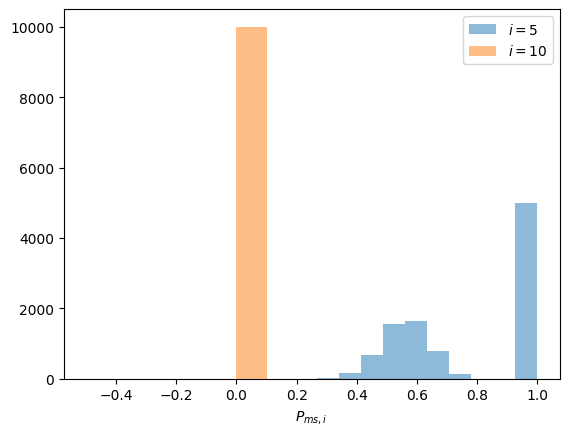

In [10]:
probs_ms = jnp.exp(samples["log_p_ms"][..., 0]) # Get the probabilities for the first of the two components (i.e., the foreground)
plt.hist(probs_ms[:, 5], label='$i=5$', alpha=0.5) # Plot for the first data point
plt.hist(probs_ms[:, 10], label='$i=10$', alpha=0.5) # ...and the sixth
plt.xlabel("$P_{ms,i}$")
plt.legend();

In [11]:
#stars that are uncertain (near 0.5 probability)
uncertain_stars = np.where((probs_ms > 0.4) & (probs_ms < 0.6))[0]
print(f"Number of uncertain stars (with 0.4 < P(MS) < 0.6): {len(uncertain_stars)}")

Number of uncertain stars (with 0.4 < P(MS) < 0.6): 121959


Q3.Graduate students: B

In [12]:
def linear_model_w_outliers_relaxed(x_data=None, y_data=None): 
    # Main Sequence (ms) priors
    m_ms = numpyro.sample('m_ms', dist.Normal(scale=10))
    b_ms = numpyro.sample('b_ms', dist.Normal(scale=20))

    σ_ms = numpyro.sample('σ_ms', dist.HalfNormal())
    μ_ms = m_ms * x_data + b_ms
    dist_ms = dist.Normal(μ_ms, σ_ms) 

    # White Dwarf (wd) priors
    m_wd = numpyro.sample('m_wd', dist.Normal(scale=10))
    b_wd = numpyro.sample('b_wd', dist.Normal(scale=20))
    
    μ_wd = m_wd * x_data + b_wd  # background prior
    σ_wd = numpyro.sample('σ_wd', dist.HalfNormal())  # scatter of white dwarfs
    dist_wd = dist.Normal(μ_wd, jnp.sqrt(σ_wd**2 + σ_ms**2)) #define background/outliers/White dwarf distribution(background model + scatter)
    
    # Prior for mixture weights (probabilities of being from MS or WD)
    p_ms = numpyro.sample('p_ms', dist.Uniform(0, 1))  # Probability of being from the MS population
    p_wd = 1 - p_ms  # Probability of being from the WD population

    # Mixture model (Categorical distribution)
    mixing_dist = dist.Categorical(probs=jnp.array([p_ms, p_wd])) 
    mixture = dist.MixtureGeneral(mixing_dist, [dist_ms, dist_wd])

    # Likelihood - observed data `y`
    with numpyro.plate("data", len(x_data)):
        y_ = numpyro.sample("obs", mixture, obs=y_data)  

        # Log probabilities to track membership probabilities of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "log_p_ms", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )

In [13]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)

# Define the kernel
kernel = NUTS(linear_model_w_outliers_relaxed)

# Initialize and run MCMC
mcmc = MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=5000
)
mcmc.run(rng_key_, x_data, y_data)

mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      b_ms      7.38      4.80      7.36      2.55     12.22      1.00    160.71
      b_wd      7.38      4.80      7.32      2.54     12.24      1.00    125.29
      m_ms      2.72      0.22      2.79      2.45      2.96      1.02      6.71
      m_wd      2.72      0.23      2.84      2.43      2.96      1.03      4.94
      p_ms      0.50      0.44      0.50      0.06      0.94      1.00    136.46
      σ_ms      0.48      0.08      0.51      0.38      0.57      1.02      6.79
      σ_wd      0.22      0.18      0.24      0.00      0.42      1.01      7.96

Number of divergences: 0


array([[<Axes: title={'center': 'b_ms'}>,
        <Axes: title={'center': 'b_ms'}>],
       [<Axes: title={'center': 'b_wd'}>,
        <Axes: title={'center': 'b_wd'}>],
       [<Axes: title={'center': 'm_ms'}>,
        <Axes: title={'center': 'm_ms'}>],
       [<Axes: title={'center': 'm_wd'}>,
        <Axes: title={'center': 'm_wd'}>],
       [<Axes: title={'center': 'p_ms'}>,
        <Axes: title={'center': 'p_ms'}>],
       [<Axes: title={'center': 'σ_ms'}>,
        <Axes: title={'center': 'σ_ms'}>],
       [<Axes: title={'center': 'σ_wd'}>,
        <Axes: title={'center': 'σ_wd'}>]], dtype=object)

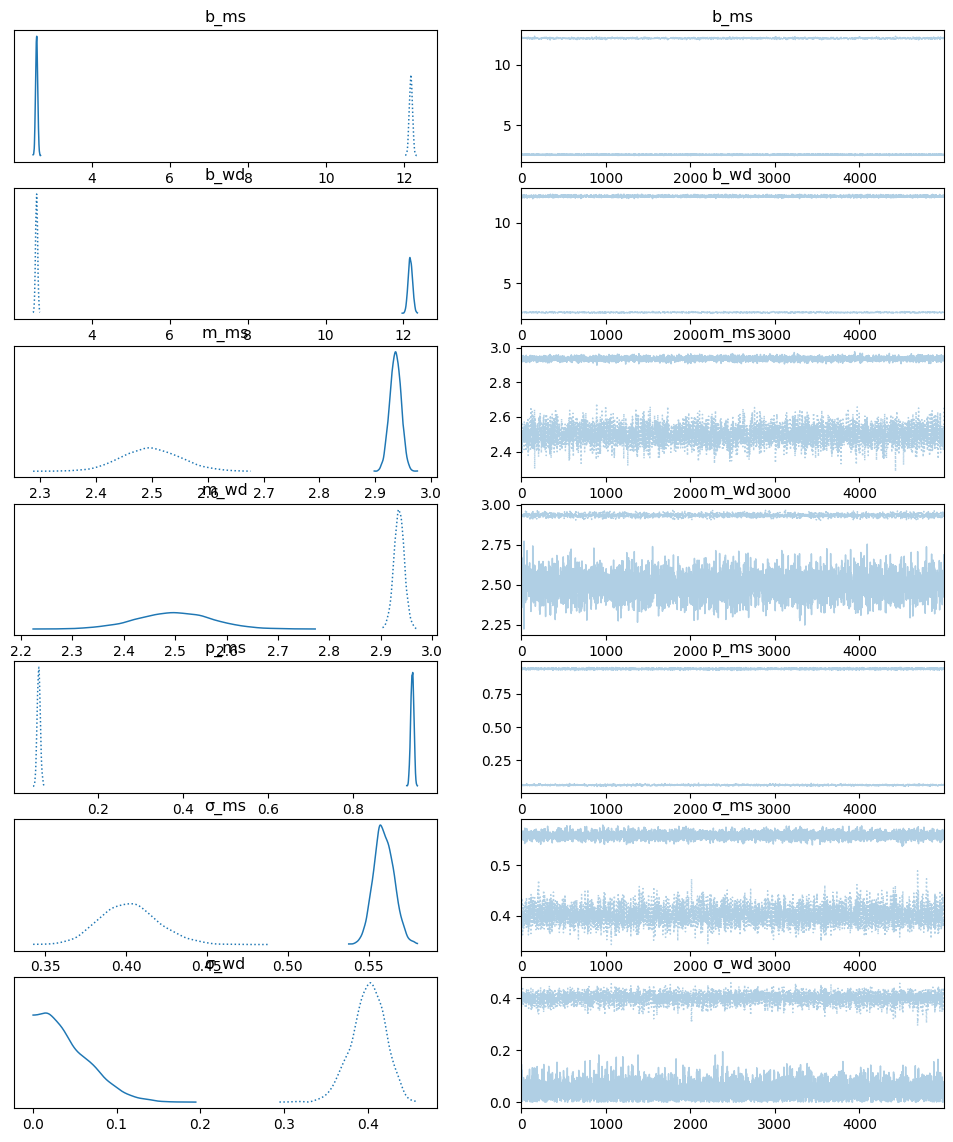

In [14]:
az.plot_trace(mcmc,var_names=['~log_p_ms*'],filter_vars='regex')

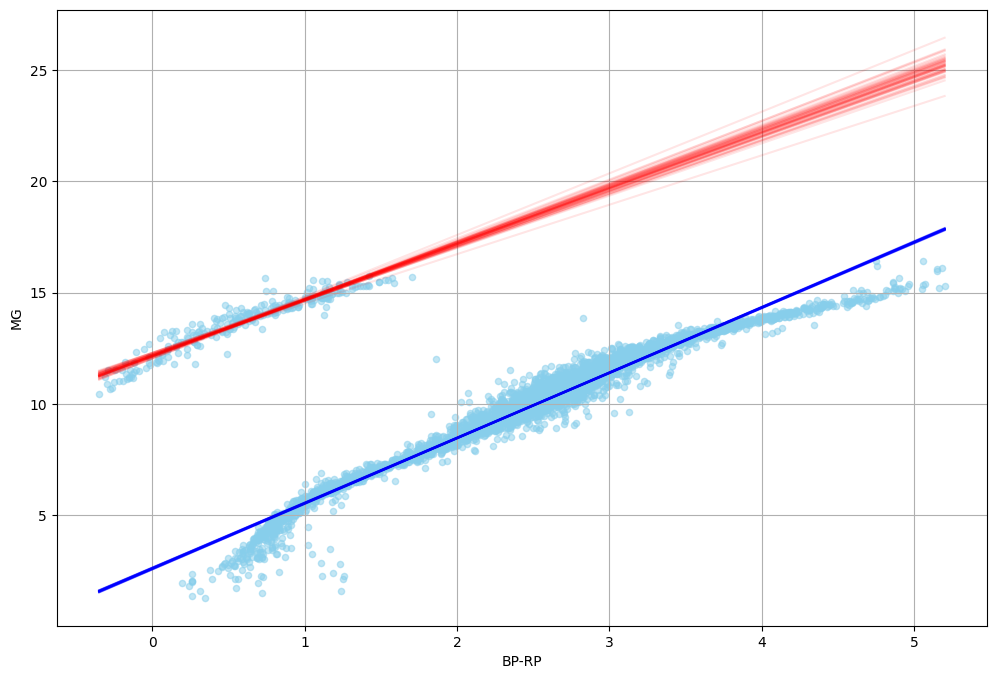

In [15]:
posterior_samples1 = mcmc.get_samples()

m_ms_samples = posterior_samples1['m_ms']
b_ms_samples = posterior_samples1['b_ms']
m_wd_samples = posterior_samples1['m_wd']
b_wd_samples = posterior_samples1['b_wd'] 

x_vals = np.linspace(min(x_data), max(x_data), 50)

plt.figure(figsize=(12,8))
plt.scatter(x_data, y_data, color='skyblue', alpha=0.5, label='Observed Data', s=20)  

for i in range(50):
    m_ms = m_ms_samples[i]
    b_ms = b_ms_samples[i]
    m_wd = m_wd_samples[i]
    b_wd = b_wd_samples[i]  

    plt.plot(x_vals, m_ms * x_vals + b_ms, color='blue', alpha=0.1)  
    plt.plot(x_vals, m_wd * x_vals + b_wd, color='red', alpha=0.1)  

plt.xlabel('BP-RP')
plt.ylabel('MG')
plt.grid(True)
plt.show()

Q3.B.Take a look at the trace plots and the fits to the data. Can you describe what's happening?

 The quality of the fit is hard to judge solely based on whether the priors are relaxed as the fit looks good making the model being reasonable. Relaxing the priors increases the scale, allowing the model to explore a wider range of parameter values. In the trace, we can see that the posterior distributions of almost all parameters are diverging, indicating that the data is not constraining the model, and it is free to explore and adjust the parameters. With a large amount of data and unconstrained priors, the model can take many different paths.